# Experiment Result

# CONTENTS

1. [P-Values Cloud](#P-Values-Cloud)
2. [Test Statistics](#Test-Statistics)
3. [Hypothesis Test Results SNLI](#Hypothesis-Test-Results-SNLI)
4. [Hypothesis Test Results MNLI](#Hypothesis-Test-Results-MNLI)
5. [Simplified Accuracy](#Acc-simplified)
6. [Best Rho Table](#Best-Rho-Table)
7. [Accuracy-to-variability ratio]("#Accuracy-to-variability-ratio")
8. [Score-to-param](#Score-to-param)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.formula.api as smf
from IPython.display import display, HTML, Markdown 
from lr.analysis.util import get_ts_from_results_folder 
from lr.stats.h_testing import get_paired_t_statistic
from matplotlib.ticker import FuncFormatter
from glob import glob

### Functions

In [2]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0f' % (x * 1e-6)

def f_percentage(x, pos):
    """
    Adds percentage sign to plot ticks.
    """

    return '{:.1%}'.format(x)

y_axis_formatter = FuncFormatter(f_percentage)

def get_ts_from_path(base_path, nli_map):
    rhos = []
    neutral_t = []
    contradiction_t = []
    entailment_t = []
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_n = df.query("label=='neutral'")
        df_c = df.query("label=='contradiction'")
        df_e = df.query("label=='entailment'")
        t_n, _,_,_ = get_paired_t_statistic(df_n)
        t_c, _,_,_ = get_paired_t_statistic(df_c)
        t_e, _,_,_ = get_paired_t_statistic(df_e)
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)
        neutral_t.append(t_n)
        contradiction_t.append(t_c)
        entailment_t.append(t_e)
        rhos.append(rho)

    neutral_t = pd.Series(neutral_t,index=rhos).sort_index()
    contradiction_t = pd.Series(contradiction_t,index=rhos).sort_index()
    entailment_t = pd.Series(entailment_t,index=rhos).sort_index()
    neutral_t.name = "neutral"
    contradiction_t.name = "contradiction"
    entailment_t.name = "entailment"
    return neutral_t, contradiction_t, entailment_t



def get_acc_from_ent(base_path, nli_map):
    rhos = []
    entailment_acc = []
    entailment_acc_t = []
    
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_e = df.query("label=='entailment'")
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)

        entailment_acc.append(df_e.A.mean())
        entailment_acc_t.append(df_e.B.mean())        
        rhos.append(rho)

    entailment_acc = pd.Series(entailment_acc,index=rhos).sort_index()
    entailment_acc_t = pd.Series(entailment_acc_t,index=rhos).sort_index()
    entailment_acc.name = "original accuracy"
    entailment_acc_t.name = "transformed accuracy"
    return entailment_acc, entailment_acc_t


def get_cloud_p_values(p_values_df, alpha=0.05, test_repetitions=5):    
    rhos = p_values_df.index
    mean_p_values = p_values_df.mean(1).values
    error_p_values = p_values_df.std(1).values
    min_p_values  = p_values_df.min(1).values


    alpha_adj = alpha / test_repetitions

    rejected_ids = []
    remain_ids = []

    for i,p in enumerate(min_p_values):
        if p < alpha_adj:
            rejected_ids.append(i)
        else:
            remain_ids.append(i)

    rhos_rejected = rhos[rejected_ids]
    rhos_remain = rhos[remain_ids]
    y_rejected = mean_p_values[rejected_ids]
    y_remain = mean_p_values[remain_ids]
    error_rejected = error_p_values[rejected_ids]
    error_remain = error_p_values[remain_ids]
    return rhos_rejected, rhos_remain, y_rejected, y_remain, error_rejected, error_remain

## P-Values Baseline

In [3]:
folder = "snli"

all_paired_t_p_values_snli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_snli.append(paired_t_p_value)
    
all_paired_t_p_values_snli = pd.concat(all_paired_t_p_values_snli, 1)
all_paired_t_p_values_snli.columns = batchs

folder = "mnli"

all_paired_t_p_values_mnli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
        
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_mnli.append(paired_t_p_value)
    
all_paired_t_p_values_mnli = pd.concat(all_paired_t_p_values_mnli, 1)
all_paired_t_p_values_mnli.columns = batchs

rhos_rejected_snli, rhos_remain_snli, y_rejected_snli, y_remain_snli, error_rejected_snli, error_remain_snli = get_cloud_p_values(all_paired_t_p_values_snli)
rhos_rejected_mnli, rhos_remain_mnli, y_rejected_mnli, y_remain_mnli, error_rejected_mnli, error_remain_mnli = get_cloud_p_values(all_paired_t_p_values_mnli)

alpha = 0.05
alpha_adj = alpha / test_repetitions

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


# P-Values-Cloud

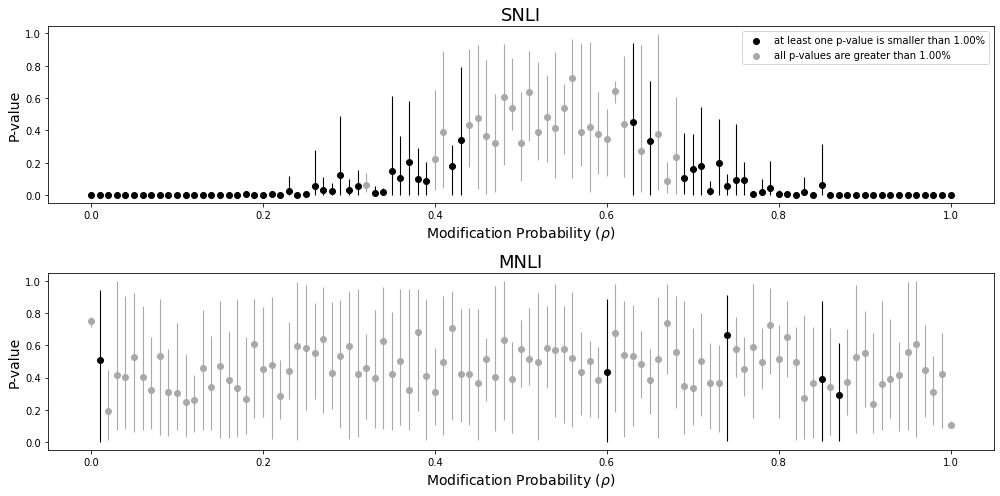

In [4]:
fig, ax = plt.subplots(2,figsize=(14,7))
ps = all_paired_t_p_values_snli
cond = ps.min(1) < alpha_adj
ps_rejected = ps[cond]
ps_retain = ps[~cond]

alpha = 1.0
linewidth = 1.1
color = "k"
ax[0].vlines(ps_rejected.index,ps_rejected.min(1),ps_rejected.max(1), alpha=alpha, linewidth=linewidth,  color=color);
ax[0].scatter(ps_rejected.index,ps_rejected.mean(1), color=color, marker="o", alpha=alpha, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
color = "darkgrey"
ax[0].vlines(ps_retain.index,ps_retain.min(1),ps_retain.max(1), alpha=alpha, linewidth=linewidth,  color=color);
ax[0].scatter(ps_retain.index,ps_retain.mean(1), color=color, marker="o", alpha=alpha, label="all p-values are greater than {:.2%}".format(alpha_adj));


ps = all_paired_t_p_values_mnli
cond = ps.min(1) < alpha_adj
ps_rejected = ps[cond]
ps_retain = ps[~cond]

color = "k"
ax[1].vlines(ps_rejected.index,ps_rejected.min(1),ps_rejected.max(1), alpha=alpha, linewidth=linewidth,  color=color);
ax[1].scatter(ps_rejected.index,ps_rejected.mean(1), color=color, marker="o", alpha=alpha);

color = "darkgrey"
ax[1].vlines(ps_retain.index,ps_retain.min(1),ps_retain.max(1), alpha=alpha, linewidth=linewidth,  color=color);
ax[1].scatter(ps_retain.index,ps_retain.mean(1), color=color, marker="o", alpha=alpha);

ax[0].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[0].set_ylabel("P-value", fontsize=14);
ax[1].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[1].set_ylabel("P-value", fontsize=14);
ax[1].set_title("MNLI", fontsize=18);
ax[0].set_title("SNLI", fontsize=18);
ax[0].legend(loc="best");

fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/paper/baseline_p_values_cloud.png', bbox_inches=None, pad_inches=0.5)


display(Markdown("# P-Values-Cloud"))

## Test Statistic for Models

In [5]:
# SNLI

model = "xgb"
folder="snli"

paired_t_p_values_snli_baseline = []
observable_paired_t_stats_snli_baseline = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_baseline.append(p)
    observable_paired_t_stats_snli_baseline.append(t)
    
paired_t_p_values_snli_baseline = pd.concat(paired_t_p_values_snli_baseline, 1)
paired_t_p_values_snli_baseline.columns = batchs
paired_t_p_values_snli_baseline = paired_t_p_values_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

observable_paired_t_stats_snli_baseline = pd.concat(observable_paired_t_stats_snli_baseline, 1)
observable_paired_t_stats_snli_baseline.columns = batchs
observable_paired_t_stats_snli_baseline = observable_paired_t_stats_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]


model = "bert_base"

paired_t_p_values_snli_bert = []
observable_paired_t_stats_snli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_bert.append(p)
    observable_paired_t_stats_snli_bert.append(t)
    
paired_t_p_values_snli_bert = pd.concat(paired_t_p_values_snli_bert, 1)
paired_t_p_values_snli_bert.columns = batchs

observable_paired_t_stats_snli_bert = pd.concat(observable_paired_t_stats_snli_bert, 1)
observable_paired_t_stats_snli_bert.columns = batchs


model = "roberta_base"

paired_t_p_values_snli_roberta = []
observable_paired_t_stats_snli_roberta = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_roberta.append(p)
    observable_paired_t_stats_snli_roberta.append(t)
    
paired_t_p_values_snli_roberta = pd.concat(paired_t_p_values_snli_roberta, 1)
paired_t_p_values_snli_roberta.columns = batchs

observable_paired_t_stats_snli_roberta = pd.concat(observable_paired_t_stats_snli_roberta, 1)
observable_paired_t_stats_snli_roberta.columns = batchs


model = "xlnet_base"

paired_t_p_values_snli_xlnet = []
observable_paired_t_stats_snli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_xlnet.append(p)
    observable_paired_t_stats_snli_xlnet.append(t)
    
paired_t_p_values_snli_xlnet = pd.concat(paired_t_p_values_snli_xlnet, 1)
paired_t_p_values_snli_xlnet.columns = batchs

observable_paired_t_stats_snli_xlnet = pd.concat(observable_paired_t_stats_snli_xlnet, 1)
observable_paired_t_stats_snli_xlnet.columns = batchs

model = "albert_base"

paired_t_p_values_snli_albert = []
observable_paired_t_stats_snli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_albert.append(p)
    observable_paired_t_stats_snli_albert.append(t)
    
paired_t_p_values_snli_albert = pd.concat(paired_t_p_values_snli_albert, 1)
paired_t_p_values_snli_albert.columns = batchs

observable_paired_t_stats_snli_albert = pd.concat(observable_paired_t_stats_snli_albert, 1)
observable_paired_t_stats_snli_albert.columns = batchs


model = "roberta_large"

paired_t_p_values_snli_roberta_large = []
observable_paired_t_stats_snli_roberta_large = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_snli_roberta_large.append(p)
    observable_paired_t_stats_snli_roberta_large.append(t)
    
paired_t_p_values_snli_roberta_large = pd.concat(paired_t_p_values_snli_roberta_large, 1)
paired_t_p_values_snli_roberta_large.columns = batchs

observable_paired_t_stats_snli_roberta_large = pd.concat(observable_paired_t_stats_snli_roberta_large, 1)
observable_paired_t_stats_snli_roberta_large.columns = batchs


# MNLI
model = "xgb"
folder="mnli"

paired_t_p_values_mnli_baseline = []
observable_paired_t_stats_mnli_baseline = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_baseline.append(p)
    observable_paired_t_stats_mnli_baseline.append(t)
    
paired_t_p_values_mnli_baseline = pd.concat(paired_t_p_values_mnli_baseline, 1)
paired_t_p_values_mnli_baseline.columns = batchs
paired_t_p_values_mnli_baseline = paired_t_p_values_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

observable_paired_t_stats_mnli_baseline = pd.concat(observable_paired_t_stats_mnli_baseline, 1)
observable_paired_t_stats_mnli_baseline.columns = batchs
observable_paired_t_stats_mnli_baseline = observable_paired_t_stats_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]


model = "bert_base"

paired_t_p_values_mnli_bert = []
observable_paired_t_stats_mnli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_bert.append(p)
    observable_paired_t_stats_mnli_bert.append(t)
    
paired_t_p_values_mnli_bert = pd.concat(paired_t_p_values_mnli_bert, 1)
paired_t_p_values_mnli_bert.columns = batchs

observable_paired_t_stats_mnli_bert = pd.concat(observable_paired_t_stats_mnli_bert, 1)
observable_paired_t_stats_mnli_bert.columns = batchs


model = "roberta_base"

paired_t_p_values_mnli_roberta = []
observable_paired_t_stats_mnli_roberta = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_roberta.append(p)
    observable_paired_t_stats_mnli_roberta.append(t)
    
paired_t_p_values_mnli_roberta = pd.concat(paired_t_p_values_mnli_roberta, 1)
paired_t_p_values_mnli_roberta.columns = batchs

observable_paired_t_stats_mnli_roberta = pd.concat(observable_paired_t_stats_mnli_roberta, 1)
observable_paired_t_stats_mnli_roberta.columns = batchs


model = "xlnet_base"

paired_t_p_values_mnli_xlnet = []
observable_paired_t_stats_mnli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_xlnet.append(p)
    observable_paired_t_stats_mnli_xlnet.append(t)
    
paired_t_p_values_mnli_xlnet = pd.concat(paired_t_p_values_mnli_xlnet, 1)
paired_t_p_values_mnli_xlnet.columns = batchs

observable_paired_t_stats_mnli_xlnet = pd.concat(observable_paired_t_stats_mnli_xlnet, 1)
observable_paired_t_stats_mnli_xlnet.columns = batchs

model = "albert_base"

paired_t_p_values_mnli_albert = []
observable_paired_t_stats_mnli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_albert.append(p)
    observable_paired_t_stats_mnli_albert.append(t)
    
paired_t_p_values_mnli_albert = pd.concat(paired_t_p_values_mnli_albert, 1)
paired_t_p_values_mnli_albert.columns = batchs

observable_paired_t_stats_mnli_albert = pd.concat(observable_paired_t_stats_mnli_albert, 1)
observable_paired_t_stats_mnli_albert.columns = batchs

model = "roberta_large"

paired_t_p_values_mnli_roberta_large = []
observable_paired_t_stats_mnli_roberta_large = []

# test_repetitions = 5
test_repetitions = 2

batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    p  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="paired_t_p_value")
    t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="observable_paired_t_stats")
    
    paired_t_p_values_mnli_roberta_large.append(p)
    observable_paired_t_stats_mnli_roberta_large.append(t)
    
paired_t_p_values_mnli_roberta_large = pd.concat(paired_t_p_values_mnli_roberta_large, 1)
paired_t_p_values_mnli_roberta_large.columns = batchs

observable_paired_t_stats_mnli_roberta_large = pd.concat(observable_paired_t_stats_mnli_roberta_large, 1)
observable_paired_t_stats_mnli_roberta_large.columns = batchs

100%|██████████| 2/2 [00:00<00:00, 20.96it/s]


# Test-Statistics

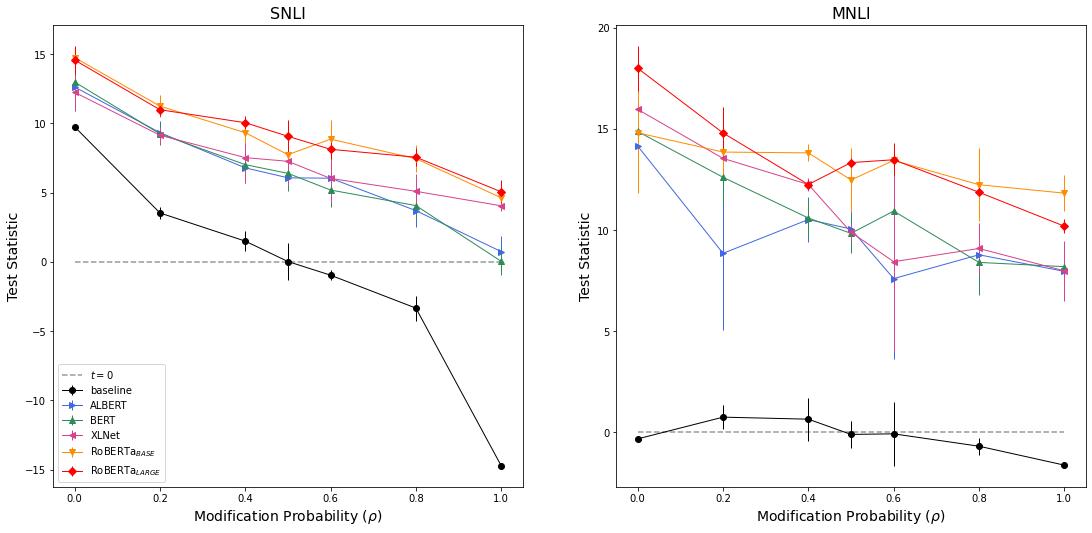

In [6]:
# PLOT

fig, ax = plt.subplots(1, 2, figsize=(18.5,8.5))
ax[0].errorbar(observable_paired_t_stats_snli_baseline.index,
            observable_paired_t_stats_snli_baseline.mean(1),
            yerr=observable_paired_t_stats_snli_baseline.std(1),
            fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");


ax[0].errorbar(observable_paired_t_stats_snli_albert.index,
            observable_paired_t_stats_snli_albert.mean(1),
            yerr=observable_paired_t_stats_snli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");


ax[0].errorbar(observable_paired_t_stats_snli_bert.index,
            observable_paired_t_stats_snli_bert.mean(1),
            yerr=observable_paired_t_stats_snli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="seagreen");



ax[0].errorbar(observable_paired_t_stats_snli_xlnet.index,
            observable_paired_t_stats_snli_xlnet.mean(1),
            yerr=observable_paired_t_stats_snli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="#d7438c");


ax[0].errorbar(observable_paired_t_stats_snli_roberta.index,
            observable_paired_t_stats_snli_roberta.mean(1),
            yerr=observable_paired_t_stats_snli_roberta.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{BASE}$",  marker="v", color="darkorange");


ax[0].errorbar(observable_paired_t_stats_snli_roberta_large.index,
            observable_paired_t_stats_snli_roberta_large.mean(1),
            yerr=observable_paired_t_stats_snli_roberta_large.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{LARGE}$",  marker="D", color="red");




ax[1].errorbar(observable_paired_t_stats_mnli_baseline.index,
            observable_paired_t_stats_mnli_baseline.mean(1),
            yerr=observable_paired_t_stats_mnli_baseline.std(1),
            fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");


ax[1].errorbar(observable_paired_t_stats_mnli_albert.index,
            observable_paired_t_stats_mnli_albert.mean(1),
            yerr=observable_paired_t_stats_mnli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");

ax[1].errorbar(observable_paired_t_stats_mnli_bert.index,
            observable_paired_t_stats_mnli_bert.mean(1),
            yerr=observable_paired_t_stats_mnli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="seagreen");


ax[1].errorbar(observable_paired_t_stats_mnli_xlnet.index,
            observable_paired_t_stats_mnli_xlnet.mean(1),
            yerr=observable_paired_t_stats_mnli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="#d7438c");



ax[1].errorbar(observable_paired_t_stats_mnli_roberta.index,
            observable_paired_t_stats_mnli_roberta.mean(1),
            yerr=observable_paired_t_stats_mnli_roberta.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{BASE}$",  marker="v", color="darkorange");

ax[1].errorbar(observable_paired_t_stats_mnli_roberta_large.index,
            observable_paired_t_stats_mnli_roberta_large.mean(1),
            yerr=observable_paired_t_stats_mnli_roberta_large.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{LARGE}$",  marker="D", color="red");



ax[0].set_title("SNLI", fontsize=16);
ax[0].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[0].set_ylabel("Test Statistic", fontsize=14);
ax[0].hlines(0,0,1, color="k", linestyle="--", alpha=0.4, label=r"$t=0$")
 

ax[1].set_title("MNLI", fontsize=16);
ax[1].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[1].set_ylabel("Test Statistic", fontsize=14);
ax[1].hlines(0,0,1, color="k", linestyle="--", alpha=0.4)
ax[0].legend(loc="lower left");

plt.subplots_adjust(hspace=0.2, wspace=0.2)
# fig.savefig('figs/paper/test_statistic.png'.format(folder),
#             bbox_inches=None, pad_inches=0.5)

display(Markdown("# Test-Statistics"))

### Number of Params

In [7]:
# Need to check baseline features exact number

deep_models = ["baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]
n_params = [50000, 109484547, 125238531, 11685891, 117311235, 356412419]
deep_models = list(zip(n_params, deep_models))
deep_models.sort()
sort_models = [i[1] for i in deep_models]
for i in sort_models:
    print(i)

baseline
ALBERT
BERT
XLNET
RoBERTa$_{BASE}$
RoBERTa$_{LARGE}$


## Hypothesis Test Results

In [8]:
obs = []

models = ["baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]

p_values = [paired_t_p_values_snli_baseline,
            paired_t_p_values_snli_bert,
            paired_t_p_values_snli_roberta,
            paired_t_p_values_snli_albert,
            paired_t_p_values_snli_xlnet,
           paired_t_p_values_snli_roberta_large]

t_stats = [observable_paired_t_stats_snli_baseline,
           observable_paired_t_stats_snli_bert,
           observable_paired_t_stats_snli_roberta,
           observable_paired_t_stats_snli_albert,
           observable_paired_t_stats_snli_xlnet,
           observable_paired_t_stats_snli_roberta_large]


for model, ps, ts in zip(models, p_values, t_stats):
    mins = ps.idxmin(1)
    mins = zip(mins.index, mins.values)
    for rho, c in mins:
        t = np.round(ts.loc[rho,c], 2)
        obs.append((model, rho, t, ps.loc[rho,c]))

table = pd.DataFrame(obs, columns =["model", r"$\rho$", "test statistic", "p-value"])
columns = pd.MultiIndex.from_product([['0.0', '0.2', '0.4', '0.5', '0.6', '0.8', '1.0'], [r'$\hat{t}$', 'p-value']],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = table.set_index(["model"]).xs(model).drop(columns=[r'$\rho$']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
final_table = final_table.loc[sort_models]

display(Markdown("# Hypothesis-Test-Results-SNLI"))
display(HTML(final_table.to_html()))

# Hypothesis-Test-Results-SNLI

In [9]:
obs = []

models = ["baseline",  "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]

p_values = [paired_t_p_values_mnli_baseline,
            paired_t_p_values_mnli_bert,
            paired_t_p_values_mnli_roberta,
            paired_t_p_values_mnli_albert,
            paired_t_p_values_mnli_xlnet,
            paired_t_p_values_mnli_roberta_large]

t_stats = [observable_paired_t_stats_mnli_baseline,
           observable_paired_t_stats_mnli_bert,
           observable_paired_t_stats_mnli_roberta,
           observable_paired_t_stats_mnli_albert,
           observable_paired_t_stats_mnli_xlnet,
           observable_paired_t_stats_mnli_roberta_large]


for model, ps, ts in zip(models, p_values, t_stats):
    mins = ps.idxmin(1)
    mins = zip(mins.index, mins.values)
    for rho, c in mins:
        t = np.round(ts.loc[rho,c], 2)
        obs.append((model, rho, t, ps.loc[rho,c]))

table = pd.DataFrame(obs, columns =["model", r"$\rho$", "test statistic", "p-value"])
columns = pd.MultiIndex.from_product([['0.0', '0.2', '0.4', '0.5', '0.6', '0.8', '1.0'], [r'$\hat{t}$', 'p-value']],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = table.set_index(["model"]).xs(model).drop(columns=[r'$\rho$']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
final_table = final_table.loc[sort_models]

display(Markdown("# Hypothesis-Test-Results-MNLI"))
display(HTML(final_table.to_html()))

# Hypothesis-Test-Results-MNLI

## Accuracy

In [10]:
# SNLI

model = "xgb"
folder = "snli"
acc_snli_baseline = []
acc_t_snli_baseline = []
diff_snli_baseline = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_baseline.append(acc)
    acc_t_snli_baseline.append(acc_t)
    diff_snli_baseline.append(diff)
    
acc_snli_baseline = pd.concat(acc_snli_baseline, 1)
acc_snli_baseline.columns = batchs
acc_snli_baseline = acc_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

acc_t_snli_baseline = pd.concat(acc_t_snli_baseline, 1)
acc_t_snli_baseline.columns = batchs
acc_t_snli_baseline = acc_t_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

diff_snli_baseline = pd.concat(diff_snli_baseline, 1)
diff_snli_baseline.columns = batchs
diff_snli_baseline = diff_snli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

model = "bert_base"
folder = "snli"
acc_snli_bert = []
acc_t_snli_bert = []
diff_snli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_bert.append(acc)
    acc_t_snli_bert.append(acc_t)
    diff_snli_bert.append(diff)
    
    
acc_snli_bert = pd.concat(acc_snli_bert, 1)
acc_snli_bert.columns = batchs

acc_t_snli_bert = pd.concat(acc_t_snli_bert, 1)
acc_t_snli_bert.columns = batchs

diff_snli_bert = pd.concat(diff_snli_bert, 1)
diff_snli_bert.columns = batchs



model = "roberta_base"
folder = "snli"
acc_snli_roberta = []
acc_t_snli_roberta = []
diff_snli_roberta = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_roberta.append(acc)
    acc_t_snli_roberta.append(acc_t)
    diff_snli_roberta.append(diff)
    
    
acc_snli_roberta = pd.concat(acc_snli_roberta, 1)
acc_snli_roberta.columns = batchs

acc_t_snli_roberta = pd.concat(acc_t_snli_roberta, 1)
acc_t_snli_roberta.columns = batchs

diff_snli_roberta = pd.concat(diff_snli_roberta, 1)
diff_snli_roberta.columns = batchs


model = "albert_base"
folder = "snli"
acc_snli_albert = []
acc_t_snli_albert = []
diff_snli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_albert.append(acc)
    acc_t_snli_albert.append(acc_t)
    diff_snli_albert.append(diff)
    
acc_snli_albert = pd.concat(acc_snli_albert, 1)
acc_snli_albert.columns = batchs

acc_t_snli_albert = pd.concat(acc_t_snli_albert, 1)
acc_t_snli_albert.columns = batchs

diff_snli_albert = pd.concat(diff_snli_albert, 1)
diff_snli_albert.columns = batchs


model = "xlnet_base"
folder = "snli"
acc_snli_xlnet = []
acc_t_snli_xlnet = []
diff_snli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_xlnet.append(acc)
    acc_t_snli_xlnet.append(acc_t)
    diff_snli_xlnet.append(diff)
    
    
acc_snli_xlnet = pd.concat(acc_snli_xlnet, 1)
acc_snli_xlnet.columns = batchs

acc_t_snli_xlnet = pd.concat(acc_t_snli_xlnet, 1)
acc_t_snli_xlnet.columns = batchs


diff_snli_xlnet = pd.concat(diff_snli_xlnet, 1)
diff_snli_xlnet.columns = batchs


model = "roberta_large"
folder = "snli"
acc_snli_roberta_large = []
acc_t_snli_roberta_large = []
diff_snli_roberta_large = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_snli_roberta_large.append(acc)
    acc_t_snli_roberta_large.append(acc_t)
    diff_snli_roberta_large.append(diff)
    
    
acc_snli_roberta_large = pd.concat(acc_snli_roberta_large, 1)
acc_snli_roberta_large.columns = batchs

acc_t_snli_roberta_large = pd.concat(acc_t_snli_roberta_large, 1)
acc_t_snli_roberta_large.columns = batchs

diff_snli_roberta_large = pd.concat(diff_snli_roberta_large, 1)
diff_snli_roberta_large.columns = batchs

100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


In [11]:
# MNLI

model = "xgb"
folder = "mnli"
acc_mnli_baseline = []
acc_t_mnli_baseline = []
diff_mnli_baseline = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_baseline.append(acc)
    acc_t_mnli_baseline.append(acc_t)
    diff_mnli_baseline.append(diff)
    
acc_mnli_baseline = pd.concat(acc_mnli_baseline, 1)
acc_mnli_baseline.columns = batchs
acc_mnli_baseline = acc_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

acc_t_mnli_baseline = pd.concat(acc_t_mnli_baseline, 1)
acc_t_mnli_baseline.columns = batchs
acc_t_mnli_baseline = acc_t_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

diff_mnli_baseline = pd.concat(diff_mnli_baseline, 1)
diff_mnli_baseline.columns = batchs
diff_mnli_baseline = diff_mnli_baseline.loc[[0.00, 0.20, 0.40, 0.50, 0.60, 0.8, 1.0]]

model = "bert_base"
folder = "mnli"
acc_mnli_bert = []
acc_t_mnli_bert = []
diff_mnli_bert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_bert.append(acc)
    acc_t_mnli_bert.append(acc_t)
    diff_mnli_bert.append(diff)
    
    
acc_mnli_bert = pd.concat(acc_mnli_bert, 1)
acc_mnli_bert.columns = batchs

acc_t_mnli_bert = pd.concat(acc_t_mnli_bert, 1)
acc_t_mnli_bert.columns = batchs

diff_mnli_bert = pd.concat(diff_mnli_bert, 1)
diff_mnli_bert.columns = batchs



model = "roberta_base"
folder = "mnli"
acc_mnli_roberta = []
acc_t_mnli_roberta = []
diff_mnli_roberta = []


test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_roberta.append(acc)
    acc_t_mnli_roberta.append(acc_t)
    diff_mnli_roberta.append(diff)
    
    
acc_mnli_roberta = pd.concat(acc_mnli_roberta, 1)
acc_mnli_roberta.columns = batchs

acc_t_mnli_roberta = pd.concat(acc_t_mnli_roberta, 1)
acc_t_mnli_roberta.columns = batchs

diff_mnli_roberta = pd.concat(diff_mnli_roberta, 1)
diff_mnli_roberta.columns = batchs


model = "albert_base"
folder = "mnli"
acc_mnli_albert = []
acc_t_mnli_albert = []
diff_mnli_albert = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_albert.append(acc)
    acc_t_mnli_albert.append(acc_t)
    diff_mnli_albert.append(diff)
    
acc_mnli_albert = pd.concat(acc_mnli_albert, 1)
acc_mnli_albert.columns = batchs

acc_t_mnli_albert = pd.concat(acc_t_mnli_albert, 1)
acc_t_mnli_albert.columns = batchs

diff_mnli_albert = pd.concat(diff_mnli_albert, 1)
diff_mnli_albert.columns = batchs


model = "xlnet_base"
folder = "mnli"
acc_mnli_xlnet = []
acc_t_mnli_xlnet = []
diff_mnli_xlnet = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_xlnet.append(acc)
    acc_t_mnli_xlnet.append(acc_t)
    diff_mnli_xlnet.append(diff)
    
    
acc_mnli_xlnet = pd.concat(acc_mnli_xlnet, 1)
acc_mnli_xlnet.columns = batchs

acc_t_mnli_xlnet = pd.concat(acc_t_mnli_xlnet, 1)
acc_t_mnli_xlnet.columns = batchs


diff_mnli_xlnet = pd.concat(diff_mnli_xlnet, 1)
diff_mnli_xlnet.columns = batchs


model = "roberta_large"
folder = "mnli"
acc_mnli_roberta_large = []
acc_t_mnli_roberta_large = []
diff_mnli_roberta_large = []


# test_repetitions = 5
test_repetitions = 2

batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    acc  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="test_accuracy")
    acc_t = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="transformed_test_accuracy")
    
    diff  = get_ts_from_results_folder(path="results/{}/{}/syn_p_h/batch{}/".format(folder,model, i),
                                                    stat="dev_plus_accuracy_difference")
    
    acc_mnli_roberta_large.append(acc)
    acc_t_mnli_roberta_large.append(acc_t)
    diff_mnli_roberta_large.append(diff)
    
    
acc_mnli_roberta_large = pd.concat(acc_mnli_roberta_large, 1)
acc_mnli_roberta_large.columns = batchs

acc_t_mnli_roberta_large = pd.concat(acc_t_mnli_roberta_large, 1)
acc_t_mnli_roberta_large.columns = batchs

diff_mnli_roberta_large = pd.concat(diff_mnli_roberta_large, 1)
diff_mnli_roberta_large.columns = batchs

100%|██████████| 2/2 [00:00<00:00, 15.59it/s]


# Accuracy-Deep-Models-SNLI

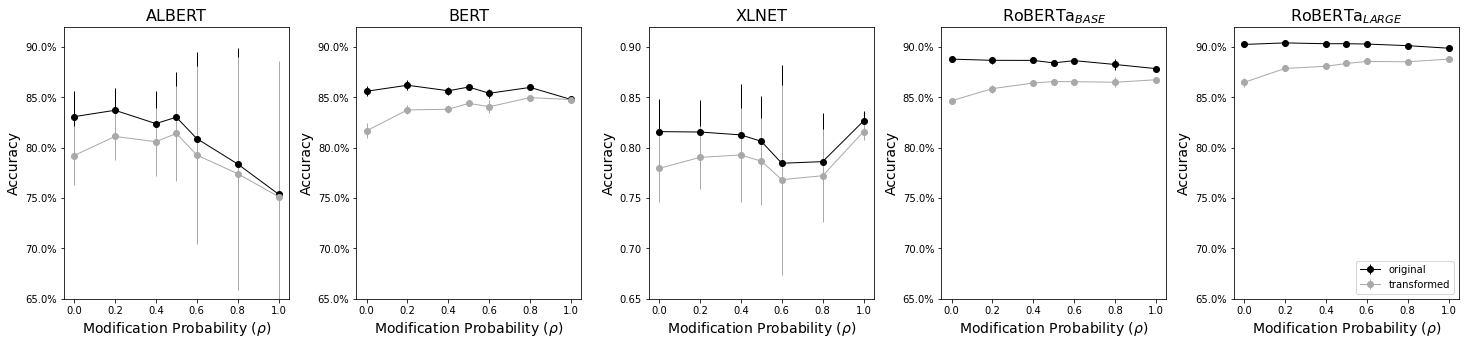

In [12]:
# PLOT

l_lim = 0.65
r_lim = 0.92

fig, ax = plt.subplots(1,5, figsize=(25,5))
ax[0].errorbar(acc_snli_albert.index, acc_snli_albert.mean(1), yerr=acc_snli_albert.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[0].errorbar(acc_t_snli_albert.index, acc_t_snli_albert.mean(1), yerr=acc_t_snli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed",  color = "darkgrey");
ax[0].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[0].set_ylabel("Accuracy", fontsize=14);
ax[0].set_title("ALBERT", fontsize=16);
ax[0].set_ylim((l_lim, r_lim))
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[1].errorbar(acc_snli_bert.index, acc_snli_bert.mean(1), yerr=acc_snli_bert.std(1), fmt='-o', linewidth=1.00, label="original", color="k");
ax[1].errorbar(acc_t_snli_bert.index, acc_t_snli_bert.mean(1), yerr=acc_t_snli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[1].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[1].set_ylabel("Accuracy", fontsize=14);
ax[1].set_title("BERT", fontsize=16);
ax[1].set_ylim((l_lim, r_lim))
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[2].errorbar(acc_snli_xlnet.index, acc_snli_xlnet.mean(1), yerr=acc_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[2].errorbar(acc_t_snli_xlnet.index, acc_t_snli_xlnet.mean(1), yerr=acc_t_snli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[2].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[2].set_ylabel("Accuracy", fontsize=14);
ax[2].set_title("XLNET", fontsize=16);
ax[2].set_ylim((l_lim, r_lim))

ax[3].errorbar(acc_snli_roberta.index, acc_snli_roberta.mean(1), yerr=acc_snli_roberta.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[3].errorbar(acc_t_snli_roberta.index, acc_t_snli_roberta.mean(1), yerr=acc_t_snli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[3].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[3].set_ylabel("Accuracy", fontsize=14);
ax[3].set_title(r"RoBERTa$_{BASE}$", fontsize=16);
ax[3].set_ylim((l_lim, r_lim))
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[4].errorbar(acc_snli_roberta_large.index, acc_snli_roberta_large.mean(1), yerr=acc_snli_roberta_large.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[4].errorbar(acc_t_snli_roberta_large.index, acc_t_snli_roberta_large.mean(1), yerr=acc_t_snli_roberta_large.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[4].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[4].set_ylabel("Accuracy", fontsize=14);
ax[4].legend(loc="lower right");
ax[4].set_title(r"RoBERTa$_{LARGE}$", fontsize=16);
ax[4].set_ylim((l_lim, r_lim))
ax[4].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.subplots_adjust(hspace=0.35, wspace=0.3);

# # fig.savefig('figs/paper/snli_acc.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-Deep-Models-SNLI"))

# Accuracy-Deep-Models-MNLI

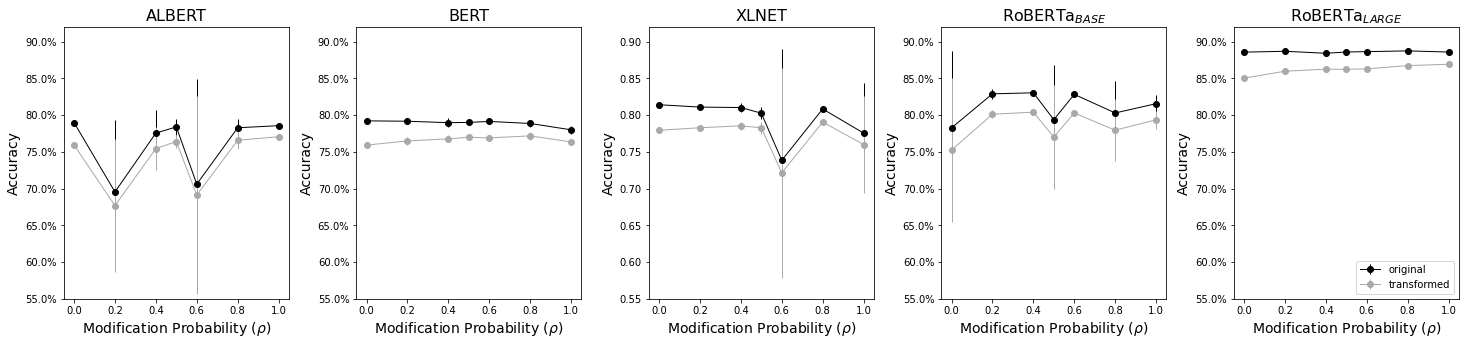

In [13]:
# PLOT

l_lim = 0.55
r_lim = 0.92

fig, ax = plt.subplots(1,5, figsize=(25,5))
ax[0].errorbar(acc_mnli_albert.index, acc_mnli_albert.mean(1), yerr=acc_mnli_albert.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[0].errorbar(acc_t_mnli_albert.index, acc_t_mnli_albert.mean(1), yerr=acc_t_mnli_albert.std(1), fmt='-o', linewidth=1.00, label="transformed",  color = "darkgrey");
ax[0].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[0].set_ylabel("Accuracy", fontsize=14);
ax[0].set_title("ALBERT", fontsize=16);
ax[0].set_ylim((l_lim, r_lim))
ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[1].errorbar(acc_mnli_bert.index, acc_mnli_bert.mean(1), yerr=acc_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="original", color="k");
ax[1].errorbar(acc_t_mnli_bert.index, acc_t_mnli_bert.mean(1), yerr=acc_t_mnli_bert.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[1].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[1].set_ylabel("Accuracy", fontsize=14);
ax[1].set_title("BERT", fontsize=16);
ax[1].set_ylim((l_lim, r_lim))
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))


ax[2].errorbar(acc_mnli_xlnet.index, acc_mnli_xlnet.mean(1), yerr=acc_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[2].errorbar(acc_t_mnli_xlnet.index, acc_t_mnli_xlnet.mean(1), yerr=acc_t_mnli_xlnet.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[2].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[2].set_ylabel("Accuracy", fontsize=14);
ax[2].set_title("XLNET", fontsize=16);
ax[2].set_ylim((l_lim, r_lim))

ax[3].errorbar(acc_mnli_roberta.index, acc_mnli_roberta.mean(1), yerr=acc_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[3].errorbar(acc_t_mnli_roberta.index, acc_t_mnli_roberta.mean(1), yerr=acc_t_mnli_roberta.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[3].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[3].set_ylabel("Accuracy", fontsize=14);
ax[3].set_title(r"RoBERTa$_{BASE}$", fontsize=16);
ax[3].set_ylim((l_lim, r_lim))
ax[3].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

ax[4].errorbar(acc_mnli_roberta_large.index, acc_mnli_roberta_large.mean(1), yerr=acc_mnli_roberta_large.std(1), fmt='-o', linewidth=1.00, label="original",  color="k");
ax[4].errorbar(acc_t_mnli_roberta_large.index, acc_t_mnli_roberta_large.mean(1), yerr=acc_t_mnli_roberta_large.std(1), fmt='-o', linewidth=1.00, label="transformed", color = "darkgrey");
ax[4].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[4].set_ylabel("Accuracy", fontsize=14);
ax[4].legend(loc="lower right");
ax[4].set_title(r"RoBERTa$_{LARGE}$", fontsize=16);
ax[4].set_ylim((l_lim, r_lim))
ax[4].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
plt.subplots_adjust(hspace=0.35, wspace=0.3);

# # fig.savefig('figs/paper/mnli_acc.png', bbox_inches=None, pad_inches=0.5)
display(Markdown("# Accuracy-Deep-Models-MNLI"))

# Acc-simplified

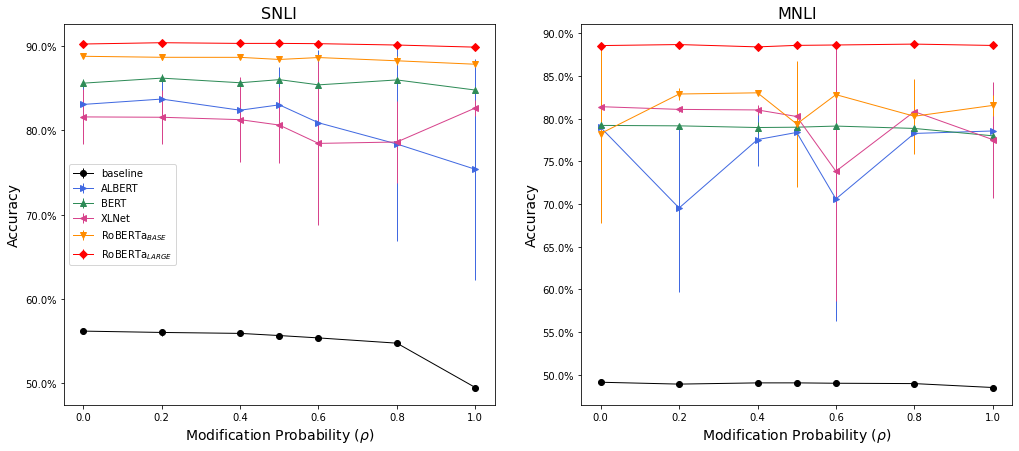

In [14]:
# PLOT

fig, ax = plt.subplots(1, 2, figsize=(17,7))

ax[0].errorbar(acc_snli_baseline.index,
            acc_snli_baseline.mean(1),
            yerr=acc_snli_baseline.std(1),
            fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");

ax[0].errorbar(acc_snli_albert.index,
            acc_snli_albert.mean(1),
            yerr=acc_snli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");


ax[0].errorbar(acc_snli_bert.index,
            acc_snli_bert.mean(1),
            yerr=acc_snli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="seagreen");



ax[0].errorbar(acc_snli_xlnet.index,
            acc_snli_xlnet.mean(1),
            yerr=acc_snli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="#d7438c");


ax[0].errorbar(acc_snli_roberta.index,
            acc_snli_roberta.mean(1),
            yerr=acc_snli_roberta.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{BASE}$",  marker="v", color="darkorange");

ax[0].errorbar(acc_snli_roberta_large.index,
              acc_snli_roberta_large.mean(1),
              yerr=acc_snli_roberta_large.std(1),
              fmt='-', linewidth=1.00, label=r"RoBERTa$_{LARGE}$",  marker="D", color="red");



ax[1].errorbar(acc_mnli_albert.index,
            acc_mnli_albert.mean(1),
            yerr=acc_mnli_albert.std(1),
            fmt='-', linewidth=1.00, label="ALBERT", marker=">", color="royalblue");


ax[1].errorbar(acc_mnli_bert.index,
            acc_mnli_bert.mean(1),
            yerr=acc_mnli_bert.std(1),
            fmt='-', linewidth=1.00, label="BERT",  marker="^", color="seagreen");



ax[1].errorbar(acc_mnli_xlnet.index,
            acc_mnli_xlnet.mean(1),
            yerr=acc_mnli_xlnet.std(1),
            fmt='-', linewidth=1.00, label="XLNet",  marker="<", color="#d7438c");


ax[1].errorbar(acc_mnli_roberta.index,
            acc_mnli_roberta.mean(1),
            yerr=acc_mnli_roberta.std(1),
            fmt='-', linewidth=1.00, label=r"RoBERTa$_{BASE}$",  marker="v", color="darkorange");

ax[1].errorbar(acc_mnli_roberta_large.index,
              acc_mnli_roberta_large.mean(1),
              yerr=acc_mnli_roberta_large.std(1),
              fmt='-', linewidth=1.00, label=r"RoBERTa$_{LARGE}$",  marker="D", color="red");

ax[1].errorbar(acc_mnli_baseline.index,
               acc_mnli_baseline.mean(1),
               yerr=acc_mnli_baseline.std(1),
               fmt='-', linewidth=1.00, label="baseline",  marker="o", color="k");



ax[0].set_title("SNLI", fontsize=16);
ax[0].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[0].set_ylabel("Accuracy", fontsize=14);
 

ax[1].set_title("MNLI", fontsize=16);
ax[1].set_xlabel(r"Modification Probability ($\rho$)", fontsize=14);
ax[1].set_ylabel("Accuracy", fontsize=14);
# ax[1].legend(loc="center right");
ax[0].legend(loc="center left");

ax[0].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
ax[1].yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

plt.subplots_adjust(hspace=0.2, wspace=0.2)
# fig.savefig('figs/paper/acc_simplified.png'.format(folder),
#             bbox_inches=None, pad_inches=0.5)

display(Markdown("# Acc-simplified"))

In [15]:
models = ["baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]
diffs = [diff_snli_baseline, diff_snli_bert,
         diff_snli_roberta, diff_snli_albert, 
         diff_snli_xlnet, diff_snli_roberta_large]

accs = [acc_snli_baseline, acc_snli_bert,
        acc_snli_roberta, acc_snli_albert, 
        acc_snli_xlnet, acc_snli_roberta_large]

accs_t = [acc_t_snli_baseline, acc_t_snli_bert,
          acc_t_snli_roberta, acc_t_snli_albert, 
          acc_t_snli_xlnet, acc_t_snli_roberta_large]

obs = []

for model,diff, acc, acc_t in zip(models, diffs, accs, accs_t):
    id_ = diff.mean(1).argmin()
    rho_star = diff.index[id_]
    obs.append((model, rho_star, acc.loc[0.0].mean(), acc.loc[rho_star].mean(), acc_t.loc[rho_star].mean()))

df = pd.DataFrame(obs, columns=["model", r"$\rho^*$","no noise test accuracy","test accuracy", "trasformed test accuracy"])
df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]] = df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]]
compare = df["no noise test accuracy"] - df["test accuracy"]
df.loc[:, "diff"] = compare*-1
df = df.drop("no noise test accuracy",1)
df[["test accuracy", "trasformed test accuracy", "diff"]] = df[["test accuracy", "trasformed test accuracy", "diff"]].apply(lambda row: row.map(lambda x: "{:.1%}".format(x)),1)
df_snli = df.copy()

models = ["baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]
diffs = [diff_mnli_baseline, diff_mnli_bert,
         diff_mnli_roberta, diff_mnli_albert, 
         diff_mnli_xlnet, diff_mnli_roberta_large]

accs = [acc_mnli_baseline, acc_mnli_bert,
        acc_mnli_roberta, acc_mnli_albert, 
        acc_mnli_xlnet, acc_mnli_roberta_large]

accs_t = [acc_t_mnli_baseline, acc_t_mnli_bert,
          acc_t_mnli_roberta, acc_t_mnli_albert, 
          acc_t_mnli_xlnet, acc_t_mnli_roberta_large]

obs = []

for model,diff, acc, acc_t in zip(models, diffs, accs, accs_t):
    id_ = diff.mean(1).argmin()
    rho_star = diff.index[id_]
    obs.append((model, rho_star, acc.loc[0.0].mean(), acc.loc[rho_star].mean(), acc_t.loc[rho_star].mean()))

df = pd.DataFrame(obs, columns=["model", r"$\rho^*$","no noise test accuracy","test accuracy", "trasformed test accuracy"])
df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]] = df[["no noise test accuracy","test accuracy", "trasformed test accuracy"]]
compare = df["no noise test accuracy"] - df["test accuracy"]
df.loc[:, "diff"] = compare*-1
df = df.drop("no noise test accuracy",1)
df[["test accuracy", "trasformed test accuracy", "diff"]] = df[["test accuracy", "trasformed test accuracy", "diff"]].apply(lambda row: row.map(lambda x: "{:.1%}".format(x)),1)
df_mnli = df.copy()

df_mnli.loc[:, "data"] = ["mnli"] * df_mnli.shape[0]
df_snli.loc[:, "data"] = ["snli"] * df_snli.shape[0]
df = pd.concat([df_snli, df_mnli])

columns = pd.MultiIndex.from_product([['SNLI', 'MNLI'], [r"$\rho^*$","test accuracy", "trasformed test accuracy", "diff"]],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = df.set_index(["model"]).xs(model).drop("data",1).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
final_table = final_table.loc[sort_models]

display(Markdown("# Best-Rho-Table"))
display(HTML(final_table.to_html()))

# Best-Rho-Table

In [16]:
obs = []

models = ["baseline", "BERT",  r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]

accs_snli = [acc_snli_baseline,
             acc_snli_bert,
             acc_snli_roberta,
             acc_snli_albert, 
             acc_snli_xlnet,
             acc_snli_roberta_large]

accs_t_snli = [acc_t_snli_baseline,
               acc_t_snli_bert,
               acc_t_snli_roberta,
               acc_t_snli_albert, 
               acc_t_snli_xlnet,
               acc_t_snli_roberta_large]

accs_mnli = [acc_mnli_baseline,
             acc_mnli_bert,
             acc_mnli_roberta,
             acc_mnli_albert, 
             acc_mnli_xlnet,
             acc_mnli_roberta_large]


accs_t_mnli = [acc_t_mnli_baseline,
               acc_t_mnli_bert,
               acc_t_mnli_roberta,
               acc_t_mnli_albert, 
               acc_t_mnli_xlnet,
               acc_t_mnli_roberta_large]

base = 0
base_t = 0

for model, acc, acc_t in zip(models, accs_snli, accs_t_snli):
    new_acc = acc.values.flatten() * 100 
    s = np.std(new_acc)
    m = np.mean(new_acc)
    sr =  (m - base) / s
    obs.append((model,"snli",m,s,sr))
    
    
base = 0
base_t = 0

for model, acc, acc_t in zip(models, accs_mnli, accs_t_mnli):
    new_acc = acc.values.flatten() * 100 
    s = np.std(new_acc)
    m = np.mean(new_acc)
    sr =  (m - base) / s
    obs.append((model,"mnli",m,s,sr))
    
    

df = pd.DataFrame(obs, columns=["model", "data", "mean accuracy", "standard deviation", "accuracy-to-variability ratio"])
av = df.groupby("model").mean().mean(1)
av = [av[model] for model in models]


columns = pd.MultiIndex.from_product([['SNLI', 'MNLI'], ["mean accuracy", "standard deviation", "accuracy-to-variability ratio"]],
                                     names=['', ' '])
new_obs = []

for model in models:
    obs = df.set_index(["model"]).xs(model).drop(columns=['data']).values.flatten()
    new_obs.append(obs)
final_table = pd.DataFrame(new_obs,columns=columns, index=models)
final_table = final_table.loc[sort_models]
display(HTML(final_table.to_html()))

In [17]:
snli_score = df.query("data=='snli'")[["model", "accuracy-to-variability ratio"]].rename(columns={"accuracy-to-variability ratio":"SNLI"})
mnli_score = df.query("data=='mnli'")[["model", "accuracy-to-variability ratio"]].rename(columns={"accuracy-to-variability ratio":"MNLI"})

df_score = pd.merge(snli_score.set_index("model"), mnli_score.set_index("model"), left_index=True, right_index=True)
df_score = df_score.reset_index()
df_score.loc[:, "average"] = (df_score.SNLI + df_score.MNLI) / 2
df_score = df_score.sort_values("average", ascending=False)
df_score.iloc[:,1:] = df_score.iloc[:,1:].apply(lambda row: row.map(lambda x: "{:.2f}".format(x)))
s = df_score.set_index("model")
s.index.name = ""
columns = pd.MultiIndex.from_product([["Signal-to-Noise Ratio"], ['SNLI', 'MNLI', "average"] ],
                                     names=['', ' '])
score_table = pd.DataFrame(s.values,columns=columns, index=s.index)
display(Markdown("# Accuracy-to-variability-ratio"))
display(HTML(score_table.to_html()))

# Accuracy-to-variability-ratio

# Score-to-param

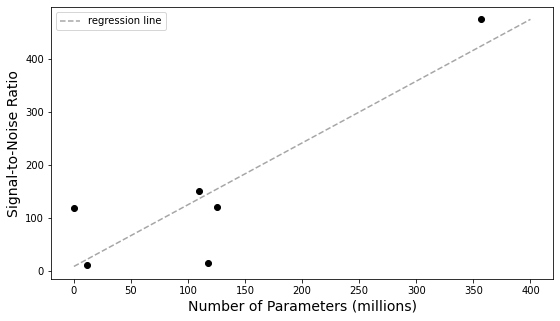

In [18]:
deep_models = ["baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]
n_params = [50000, 109484547, 125238531, 11685891, 117311235, 356412419]
deep_models = list(zip(n_params, deep_models))
deep_models.sort()
n_params = [i[0] for i in deep_models]
score =  (final_table[('SNLI', 'accuracy-to-variability ratio')] + final_table[('MNLI', 'accuracy-to-variability ratio')])  / 2
score.name = "score"
score.index.name = "model"
score = score.reset_index()
score.loc[:, "params"] = n_params

# using some dummy data for this example
xs_score = score.params.values
ys_score = score.score.values
labels_score = score.model.values

mod = smf.ols(formula='score ~ params', data=score)
res_score = mod.fit()
beta0, beta1 = res_score.params

f_score = lambda x: beta1*x + beta0
x_score = np.linspace(0, 4.0e8, 400)
y_score = f_score(x_score)


fig, ax = plt.subplots(figsize=(9,5))

# plot the chart
ax.plot(x_score, y_score, color="k", linestyle="--", alpha=0.35, label="regression line")
ax.scatter(xs_score,ys_score, color="k")

ax.set_xlabel("Number of Parameters (millions)", fontsize=14);
ax.set_ylabel("Signal-to-Noise Ratio", fontsize=14);
ax.xaxis.set_major_formatter(FuncFormatter(millions))
ax.legend(loc="upper left");
display(Markdown("# Score-to-param"))
# fig.savefig('figs/paper/score_params.png', bbox_inches=None, pad_inches=0.5)

In [19]:
"corr = {:.3f}".format(np.corrcoef(xs_score,ys_score)[0,1])

'corr = 0.878'

In [20]:
res_score.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     13.40
Date:                Mon, 29 Jun 2020   Prob (F-statistic):             0.0216
Time:                        14:11:55   Log-Likelihood:                -34.374
No. Observations:                   6   AIC:                             72.75
Df Residuals:                       4   BIC:                             72.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3951     53.324      0.157      0.883    -139.655     156.445
params      1.165e-06   3.18e-07      3.661      0.022    2.81e-07    2.05e-06
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.595
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.187
Skew:                          -0.315   Prob(JB):                        0.911
Kurtosis:                       2.407   Cond. No.                     2.40e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Reflexion about robustness score
### Including a model with $\sigma=0$

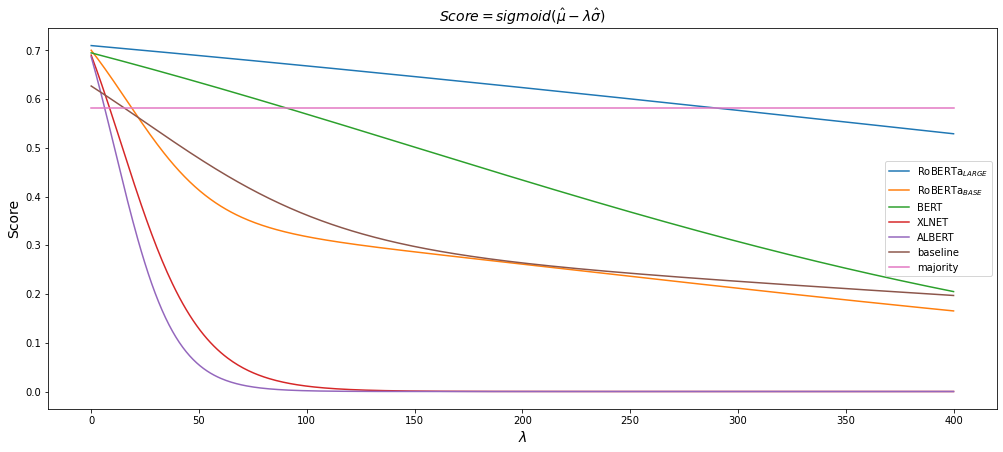

In [21]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_score(acc, l):
    m = np.mean(acc)
    s = np.std(acc)
    return sigmoid(m - l*s)

models = ["majority","baseline", "BERT", r"RoBERTa$_{BASE}$", "ALBERT", "XLNET", r"RoBERTa$_{LARGE}$"]
n_params = [0, 50000, 109484547, 125238531, 11685891, 117311235, 356412419]
major = pd.Series(np.repeat(1/3,35))


def get_score_all(lambda_):
    l = lambda_

    accs = [major, acc_snli_baseline, acc_snli_bert,
            acc_snli_roberta, acc_snli_albert, 
            acc_snli_xlnet, acc_snli_roberta_large]


    obs = []

    for model, acc, nparam in zip(models,accs, n_params):
        acc = acc.values.flatten()
        obs.append((model, nparam, get_score(acc, l)))

    a = pd.DataFrame(obs, columns=["model", "params", "score"])
    a.sort_values("score", ascending=False)

    accs = [major, acc_mnli_baseline, acc_mnli_bert,
            acc_mnli_roberta, acc_mnli_albert, 
            acc_mnli_xlnet, acc_mnli_roberta_large]


    obs = []

    for model, acc, nparam in zip(models,accs, n_params):
        acc = acc.values.flatten()
        obs.append((model, nparam, get_score(acc, l)))

    b = pd.DataFrame(obs, columns=["model", "params", "score"])
    a = a.set_index("model").score
    a.name = "SNLI"
    b = b.set_index("model").score
    b.name = "MNLI"

    df_score = pd.concat([a,b], 1)
    df_score.loc[:, "average"] = (df_score.SNLI + df_score.MNLI) / 2
    df_score = df_score.sort_values("average", ascending=False)
    return df_score

obs = []
s = 500
upper_bound = 400

for l in np.linspace(0,upper_bound, s):
    av = get_score_all(l).average
    av.name = l
    obs.append(av)
    
obs = pd.concat(obs,1).transpose()
fig, ax = plt.subplots(figsize=(17,7))
obs.plot(ax=ax);
ax.set_xlabel(r"$\lambda$", fontsize=14);
ax.set_ylabel("Score", fontsize=14);
ax.set_title(r"$Score =sigmoid(\hat{\mu} - \lambda \hat{\sigma})$", fontsize=14);